# Features specific contribution

**(Same as Readme)**

Different methods to compute the specific contribution of a groups of features X = [A, B, C] to predict a target Y.

**Objective**

We aim at computing the specific contribution of different groups of features contained in X (ex: X = [A, B, C], with A, B, C having different dimensionality) 
to predict each dimension of a target Y.

(Note that would like to keep track of the contribution for each dimension of Y). 

We use the three methods below. 
All three methods are coded in the `src/get_contrib.py` file, and are called by the `run_experiments()` function contained in `src/run_experiments.py`.
The three functions take as inputs: `X`, `y`, `hiearchy` (e.g [0, 0, 0, 1, 1, 2], with 0 (resp. 1 and 2) refering to the indices of A (resp. B and C) in X),
the predictive scikit-learn `model`, and the three parameters `scale` (whether to scale per group), `n_repeats` (for permutation importance) 
and `pca` (number of components if we apply PCA to each group before fitting).

**Method 1: "permute_current"**

Function `contrib_permute_current()` in `get_contrib.py`
+ (optional) Scale each group of features separately
+ (optional) PCA on each group
+ orthogonalize
+ concatenate features
+ fit on train
+ compute permutation importance, for each feature group separately, on test
+ re-iterate on folds


**Method 2: "permute_below"**

Function `contrib_permute_below()` in `get_contrib.py`

+ (optional) Scale each group of features separately
+ (optional) PCA on each group
+ concatenate features
+ fit on train
+ compute permutation importance, for (`+` refers to concatenation)
    * the first group A: `importance[A] = r - r_with_A_shuffled`
    * the first + second group: `importance(A+B) = r - r_with_A_and_B_shuffled`
    * the first + second + third group: `importance(A+B+C) = r - r_with_A_and_B_and_C_shuffled`
    * ... 
    * all groups shuffled
+ extract specific contribution for each level
    * `contrib_A = importance(A)`
    * `contrib_B = importance(A+B) - importance of first group (A)`
    * ... 
+ re-iterate on folds


**Method 3: "concat"**

Function `contrib_concat()` in `get_contrib.py`

+ (optional) Scale each group of features separately
+ (optional) PCA on each group
+ concatenate features
+ in order to predict Y, fit in hiearchical order and compute scores of: (`+` refers to concatenation)
    * the first group A: `r(A)`
    * the first + second group: `r(A+B)`
    * ... 
+ extract specific contribution for each level
    * `contrib_A = r(A)`
    * `contrib_B = r(A+B) - r(A)`
    * `contrib_C = r(A+B+C) - r(A+B)`
    
    
    
**Parameters**

Each function computes the contribution of feature groups (e.g [A, B, C]),
indicated in the parameter `hierarchy`.
Ex: if hierarchy = [0, 0, 0, 1, 1, 2] (n_groups=3), and y is shape (n, 10)
(y_dim=10), each method would return an array of shape (n_groups, y_dim) = (3, 10), giving
the contribution of each group to the prediction of a particular dimension.

Each function takes as input:

* **X** : array of shape `(n, x_dim)`
  - features
* **y** : array of shape `(n, y_dim)`
  - target
* **hierarchy** : array of int of shape (x_dim). 
    - Indices of the group for each feature.
    - Ex: [0, 0, 0, 1, 1, 2] refers to 3 groups, the first with dim=3, second with dim=2, last dim=1
* **model** : sklearn model, optional, by default RidgeCV(np.logspace(-2, 8, 20)). 
    - Predictive model used
      - to predict y given X,
      - if exp="permute_one", the model is also used to orthogonlize features
* **scale** : bool, optional. 
    - Whether to scale each group of features (independantly) before fitting, by default True
* **n_repeats** : int, optional. 
    - Number of repeats for exp "permute_xxx", by default 50.
    - Scores are always averaged across repeats.
* **pca** : int, optional.
    - If > 0, PCA is applied to each group of features 
    (independantly) before fitting, refers to the number 
    of components to use in the PCA, by default 20.

**Returns**

Each function outputs:

* **importance** : an array of shape `(n_groups, y_dim)`, 
    with n_groups = len(unique(hierarchy))
    `importance[i, j]` gives the contribution of features
    group i for th prediction of y_j.


# Imports and function

In [1]:
from src.run_experiment import run_experiment

In [2]:
import numpy as np
import seaborn as sns
import time
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def build_summary_df(score, experiments, pca_vals, groups, dims, dim_label='y_dim', timer=None):
    
    # Build score df
    feats = ['exp', 'pca', 'x_group', dim_label,]
    index = pd.MultiIndex.from_product([experiments, pca_vals, groups, dims],
                                       names=feats)
    df = pd.DataFrame({'score': score.flatten()}, index=index)
    
    if timer is not None:
        # Build time df
        feats = ['exp', 'pca',]
        index = pd.MultiIndex.from_product([experiments, pca_vals],
                                               names=feats)
        df_time = pd.DataFrame({'time': timer.flatten()}, index=index)

        # Merge score and time dfs
        df = df.join(df_time)
    
    return df.reset_index()

# Runs

## Simple experiment

In [4]:
n = 5000

# Generate X 
counts = [50, 100, 50, 200]
hierarchy = np.repeat(np.arange(len(counts)), counts)
n_levels = len(np.unique(hierarchy))
rng = np.random.RandomState(42)
A = rng.rand(n, counts[0])
B = rng.rand(n, counts[1])
C = rng.rand(n, counts[2])
D = rng.rand(n, counts[3])
noise = rng.normal(0, 1, n)
X = np.concatenate([A, B, C, D], axis=1)

# Generate Y 
Y = [A[:, 0] + B[:, 1] + C[:, 0] + noise,]
Y = np.stack(Y, axis=1)

# Set params
experiments = ["permute_current", "permute_below", "concat", "concat_pca"]
pca_vals = [0]
groups = ['A', 'B', 'C', 'D']
dims = np.arange(Y.shape[-1])

# Run exp
score = np.zeros((len(experiments), len(pca_vals), n_levels, Y.shape[1]))
timer = np.zeros((len(experiments), len(pca_vals)))
for i, exp in enumerate(experiments):
    for j, pca in enumerate(pca_vals):
        start = time.time()
        score[i, j] = run_experiment(exp, X, Y, hierarchy, n_repeats=50, scale=True, pca=pca)
        timer[i, j] = time.time() - start

..........

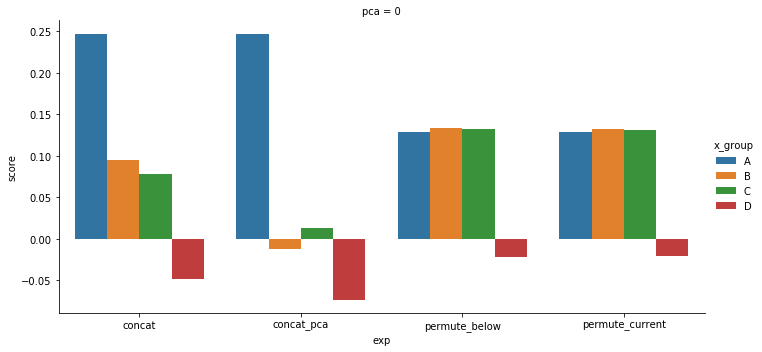

In [5]:
# Build df 
df = build_summary_df(score, experiments, pca_vals, groups, dims, timer=timer)

# Plot
df_plot = df.groupby(['exp', 'pca', 'x_group'])['score'].agg('mean').reset_index()
sns.catplot('exp', 'score', hue='x_group', data=df_plot, col='pca', kind='bar', aspect=2)
plt.show()


## Noise experiment

In [6]:
# Generate Y
K = 10
Y = [A[:, 0] + B[:, 1] + C[:, 0] + np.random.normal(0, k/2, n) for k in range(K)]
Y = np.stack(Y, axis=1)

# Compute scores
score = np.zeros((len(experiments), len(pca_vals), n_levels, K))
timer = np.zeros((len(experiments), len(pca_vals)))
for i, exp in enumerate(experiments):
    for j, pca in enumerate(pca_vals):
        start = time.time()
        score[i, j] = run_experiment(exp, X, Y, hierarchy, n_repeats=50, scale=True, pca=pca)
        timer[i, j] = time.time() - start

..........

In [7]:
# Build df 
df = build_summary_df(score, experiments, pca_vals, groups, range(Y.shape[1]), dim_label="noise", timer=timer)

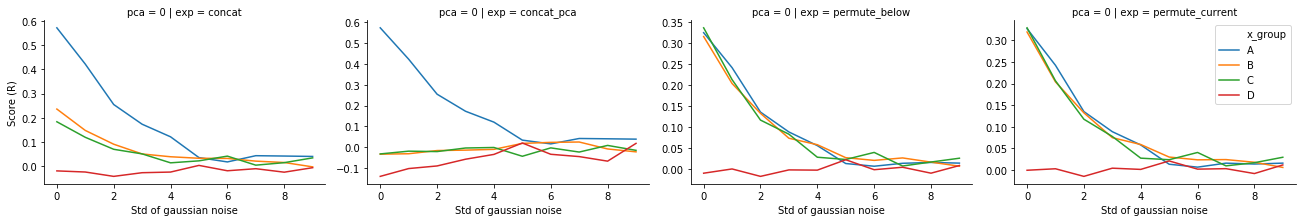

In [8]:
# Plot
g = sns.FacetGrid(df, col="exp", row="pca", aspect=1.5, sharey=False)
g.map_dataframe(sns.lineplot, x="noise", y="score", hue="x_group")
g.set_axis_labels("Std of gaussian noise", "Score (R)")
plt.legend()
plt.show()

## Colinearity

### A = B

In [12]:
n = 5000

# Generate A, B, C, D
counts = [50, 50, 50, 200]
hierarchy = np.repeat(np.arange(len(counts)), counts)
n_levels = len(np.unique(hierarchy))
rng = np.random.RandomState(42)
A = rng.rand(n, counts[0])
B = A
#B = rng.rand(n, counts[1])
C = rng.rand(n, counts[2])
D = rng.rand(n, counts[3])
noise = rng.normal(0, 1, n)

# Generate X
X = np.concatenate([A, B, C, D], axis=1)

# Generate Y 
Y = [A[:, 0] + B[:, 1] + C[:, 0] + noise,]
Y = np.stack(Y, axis=1)

# Set params
experiments = ["permute_current", "permute_below", "concat", "concat_pca"]
pca_vals = [0]
groups = ['A', 'B', 'C', 'D']
dims = np.arange(Y.shape[-1])

# Run exp
score = np.zeros((len(experiments), len(pca_vals), n_levels, Y.shape[1]))
timer = np.zeros((len(experiments), len(pca_vals)))
for i, exp in enumerate(experiments):
    for j, pca in enumerate(pca_vals):
        start = time.time()
        score[i, j] = run_experiment(exp, X, Y, hierarchy, n_repeats=50, scale=True, pca=pca)
        timer[i, j] = time.time() - start

..........

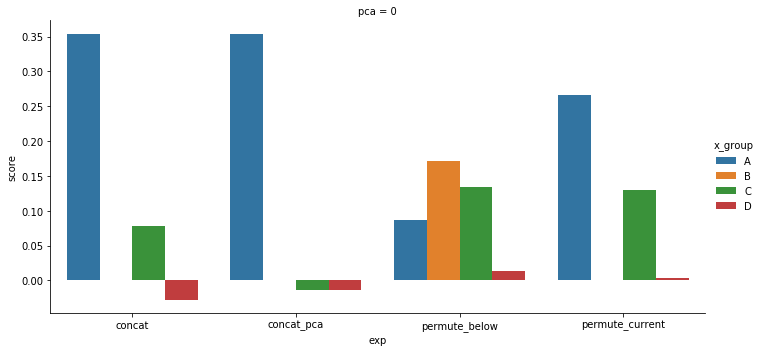

In [13]:
# Build df 
df = build_summary_df(score, experiments, pca_vals, groups, dims, timer=timer)

# Plot
df_plot = df.groupby(['exp', 'pca', 'x_group'])['score'].agg('mean').reset_index()
sns.catplot('exp', 'score', hue='x_group', data=df_plot, col='pca', kind='bar', aspect=2)
plt.show()

### A = B + noise

In [24]:
n = 5000

# Generate A, B, C, D
counts = [50, 50, 50, 200]
hierarchy = np.repeat(np.arange(len(counts)), counts)
n_levels = len(np.unique(hierarchy))
rng = np.random.RandomState(42)
B = rng.rand(n, counts[0])
#B = rng.rand(n, counts[1])
C = rng.rand(n, counts[2])
D = rng.rand(n, counts[3])
noise = rng.normal(0, 1, n)

# Set params
experiments = ["permute_current", "permute_below", "concat", "concat_pca"]
pca_vals = [0]
groups = ['A', 'B', 'C', 'D']
noises = np.linspace(0, 5, 10)

# Run exp
score = np.zeros((len(experiments), len(pca_vals), n_levels, len(noises)))
timer = np.zeros((len(experiments), len(pca_vals)))
for i, exp in enumerate(experiments):
    for j, pca in enumerate(pca_vals):
        for k, std in enumerate(noises):
            
            # Generate X
            A = B + rng.normal(0, std, A.shape)
            X = np.concatenate([A, B, C, D], axis=1)

            # Generate Y 
            Y = [B[:, 0] + B[:, 0] + C[:, 0] + noise]
            Y = np.stack(Y, axis=1)

            start = time.time()
            r_multidim = run_experiment(exp, X, Y, hierarchy, n_repeats=50, scale=True, pca=pca)
            score[i, j, :, k] = r_multidim.mean(-1)
            timer[i, j] = time.time() - start

....................................................................................................

In [25]:
df = build_summary_df(score, experiments, pca_vals, groups, noises, dim_label="corr")

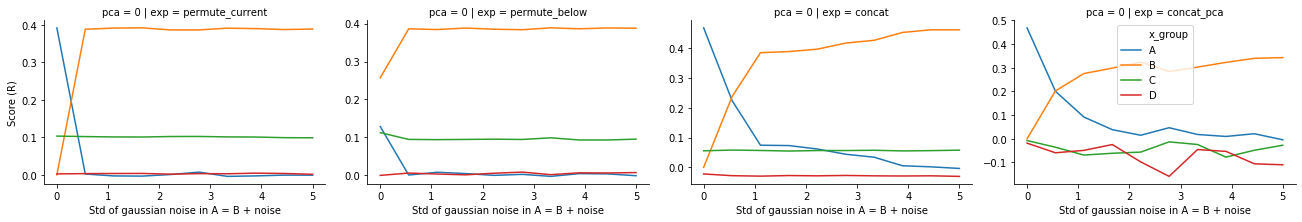

In [27]:
g = sns.FacetGrid(df, col="exp", row="pca", aspect=1.5, sharey=False)
g.map_dataframe(sns.lineplot, x="corr", y="score", hue="x_group")
g.set_axis_labels("Std of gaussian noise in A = B + noise\n X = [B_0, B_0, C_0]", "Score (R)")
plt.legend()
plt.show()

## Non linear relationship

In [33]:
n = 5000

# Generate A, B, C, D
counts = [50, 100, 50, 200]
hierarchy = np.repeat(np.arange(len(counts)), counts)
n_levels = len(np.unique(hierarchy))
rng = np.random.RandomState(42)
A = rng.rand(n, counts[0])
B = rng.rand(n, counts[1])
C = rng.rand(n, counts[2])
D = rng.rand(n, counts[3])
noise = rng.normal(0, 1, n)

# Generate X
X = np.concatenate([A, B, C, D], axis=1)

# Generate Y 
Y = [1/A[:, 0]**2 + noise,]
Y = np.stack(Y, axis=1)

# Set params
experiments = ["permute_current", "permute_below", "concat", "concat_pca"]
pca_vals = [0]
groups = ['A', 'B', 'C', 'D']
dims = np.arange(Y.shape[-1])

# Run exp
score = np.zeros((len(experiments), len(pca_vals), n_levels, Y.shape[1]))
timer = np.zeros((len(experiments), len(pca_vals)))
for i, exp in enumerate(experiments):
    for j, pca in enumerate(pca_vals):
        start = time.time()
        score[i, j] = run_experiment(exp, X, Y, hierarchy, n_repeats=50, scale=True, pca=pca)
        timer[i, j] = time.time() - start

..........

### Linear model

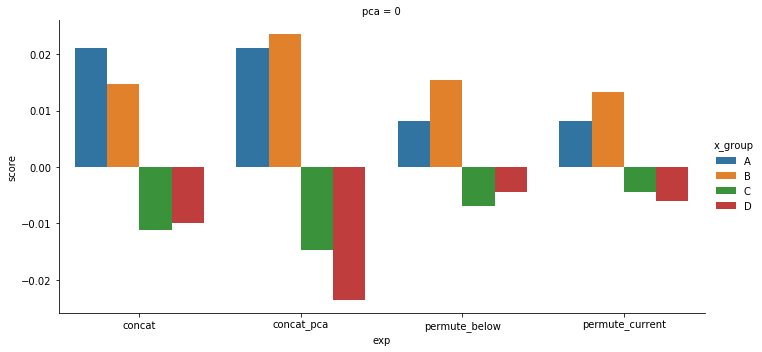

In [34]:
# Build df 
df = build_summary_df(score, experiments, pca_vals, groups, dims, timer=timer)

# Plot
df_plot = df.groupby(['exp', 'pca', 'x_group'])['score'].agg('mean').reset_index()
sns.catplot('exp', 'score', hue='x_group', data=df_plot, col='pca', kind='bar', aspect=2)
plt.show()

### Non linear model

In [35]:
def uni_r_metric(y_pred, y_true):
    return pearsonr(y_true, y_pred)[0]
    

In [36]:
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import pearsonr
# Run exp
score = np.zeros((len(experiments), len(pca_vals), n_levels))
timer = np.zeros((len(experiments), len(pca_vals)))
for i, exp in enumerate(experiments):
    for j, pca in enumerate(pca_vals):
        start = time.time()
        score[i, j] = run_experiment(exp, X, Y[:, 0], hierarchy, n_repeats=10, scale=True, pca=pca, 
                                     model=RandomForestRegressor(max_depth=5), metric=uni_r_metric)
        timer[i, j] = time.time() - start

..........

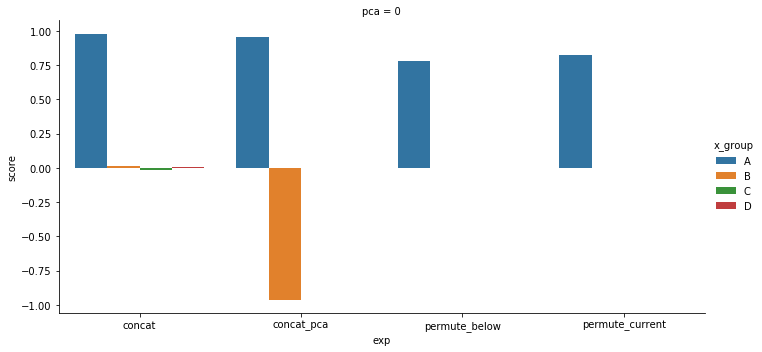

In [37]:
# Build df 
df = build_summary_df(score, experiments, pca_vals, groups, dims, timer=timer)

# Plot
df_plot = df.groupby(['exp', 'pca', 'x_group'])['score'].agg('mean').reset_index()
sns.catplot('exp', 'score', hue='x_group', data=df_plot, col='pca', kind='bar', aspect=2)
plt.show()

## Dimensionality experiment

In [43]:
n = 5000

# Generate A, C, D
counts = [50, 50, 50, 200]
hierarchy = np.repeat(np.arange(len(counts)), counts)
n_levels = len(np.unique(hierarchy))
rng = np.random.RandomState(42)
A = rng.rand(n, counts[0])
C = rng.rand(n, counts[2])
D = rng.rand(n, counts[3])

dims = np.unique(np.logspace(0, 3, 15).astype(int))
print(len(dims))
score = np.zeros((len(experiments), len(pca_vals), n_levels, len(dims)))
timer = np.zeros((len(experiments), len(pca_vals), len(dims)))

for d, dim in enumerate(dims):
    print(d)
    
    # Generate B
    counts[1] = dim
    hierarchy = np.repeat(np.arange(len(counts)), counts)
    B = np.random.rand(n, counts[1])
    
    # Generate X
    X = np.concatenate([A, B, C, D], axis=1)
    
    # Generate Y
    Y = A[:, 0] + B[:, 0] + C[:, 0]
    Y = Y[:, None]
    
    # Compute score
    for i, exp in enumerate(experiments):
        for j, pca in enumerate(pca_vals):
            start = time.time()
            r_multidim = run_experiment(exp, X, Y, hierarchy, n_repeats=50, scale=True, pca=pca
                                       )
            score[i, j, :, d] = r_multidim.mean(-1)
            timer[i, j, d] = time.time() - start

14
0
..........1
..........2
..........3
..........4
..........5
..........6
..........7
..........8
..........9
..........10
..........11
..........12
..........13
..........

In [44]:
df = build_summary_df(score, experiments, pca_vals, groups, dims, dim_label="B_dim")

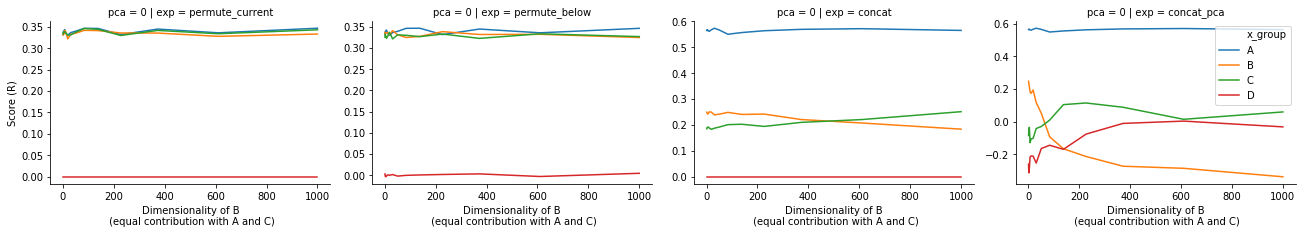

In [45]:
g = sns.FacetGrid(df, col="exp", row="pca", aspect=1.5, sharey=False)
g.map_dataframe(sns.lineplot, x="B_dim", y="score", hue="x_group")
g.set_axis_labels("Dimensionality of B\n (equal contribution with A and C)", "Score (R)")
plt.legend()
plt.show()